In [1]:
import itertools
from duckduckgo_search import ddg_images

#!pip install fastai duckduckgo_search
from fastai.vision.all import *

from fastai.vision.utils import download_images;

Start with a classifier based on the [Lesson 0 Notebook](https://github.com/fastai/course22/blob/master/00-is-it-a-bird-creating-a-model-from-your-own-data.ipynb)


In [2]:
from fastai.data.transforms import get_image_files
from fastai.vision.utils import resize_images, verify_images
from fastcore.all import *

def search_images(term, max_images=200):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

# Categories should work both as search term and directory name
#For simplicity: keep these in alphabetical order
categories = (
    'Dall-E', 'Midjourney', 'Stable Diffusion',
)

search_terms = (
    'Generated with %s',
)
imgs_per_category = 10

path = Path('midge_or_not')
for label in categories:
    dest = path/label
    dest.mkdir(exist_ok=True, parents=True)
    urls = []
    for search_term in search_terms:
        urls.extend(search_images(search_term % label, imgs_per_category))
    download_images(dest, urls=urls)
    resize_images(dest, max_size=400, dest=dest)

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f'removed {len(failed)} bad images')

removed 16 bad images


In [3]:
urls[0]

'https://miro.medium.com/max/1200/1*UXJeqjcXsDSMEH3F_Ufr7g.jpeg'

Note that using the data is pretty dirty -- we have images like this:

<img src="https://www.allabtai.com/wp-content/uploads/2022/11/midjourney-v4-vs-stable-diffusion-v2.3-768x432.jpg" width="70%"/>

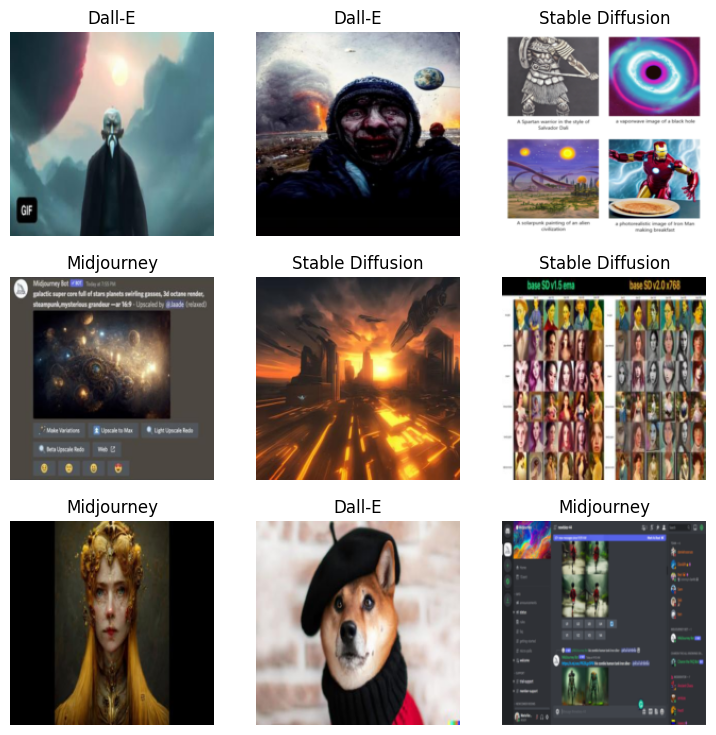

In [4]:
from fastai.vision.augment import Resize
from fastai.data.transforms import RandomSplitter, parent_label
from fastai.vision.data import ImageBlock
from fastai.data.block import DataBlock, CategoryBlock

datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)
loaders = datablock.dataloaders(path)
loaders.show_batch()

In [7]:
import torch
from fastai.vision.learner import vision_learner
from fastai.metrics import error_rate
from torchvision.models import resnet18


learn = vision_learner(loaders, resnet18, metrics=error_rate)
learn.fine_tune(3)

In [9]:
learn.validate()

(#2) [0.10856466740369797,0.03278687596321106]

In [13]:
learn.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  